# Import Libraries

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from glob import glob

In [2]:
from math import log10
def eng_str(x, u=0, n=1):
    """Print formatted value and its uncertainty in engineering format"""
    y = abs(x)
    exponent = int(log10(y))
    engr_exponent = exponent - exponent%3
    z = y/10**engr_exponent
    sign = '-' if x < 0 else ''
    fmt = "{z:.%df}" % (n)
    xStr = sign+fmt.format(z=z)
    
    # uncertainty
    yU = abs(u)
    zU = yU/10**engr_exponent
    fmtU = "{zU:.%df}" % (n)
    if engr_exponent != 0:
        uStr = " ± "+fmtU.format(zU=zU)+'e'+str(engr_exponent)
    else:
        uStr = " ± "+fmtU.format(zU=zU)
    return xStr + uStr

print(eng_str(123456, 3456, n=1))

123.5 ± 3.5e3


# Read in Your Data
The `glob` function allows you to find files whose names match a pattern. We are looking in the folder `Data` for files ending with `.csv`.

0: Data/2022-07-08-1331.csv
1: Data/2022-07-08-1331a.csv
2: Data/2022-07-08-1331b.csv
3: Data/2022-07-08-1331c.csv
4: Data/2022-07-08-1331d.csv
5: Data/2022-07-08-1331e.csv
Enter file number: 5
Getting data from Data/2022-07-08-1331e.csv


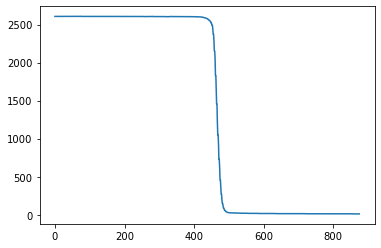

In [3]:
dataFolder = "Data"
globMatch = "*.csv"
files = glob("/".join([dataFolder,globMatch]))
files.sort()
for (i, f) in enumerate(files):
    print("{}: {}".format(i, f))
iFile = int(input("Enter file number: "))
dataFile = files[iFile]
figName = "Figures/" + dataFile[dataFile.find("/")+1:dataFile.rfind('.')] + r"_%.03d.png"

print("Getting data from {}".format(dataFile))
data = np.genfromtxt(dataFile, comments='#', delimiter=',')
pos = data[:,1]
I = data[:,3]
# Do a quick plot
plt.plot(pos, I)
pass

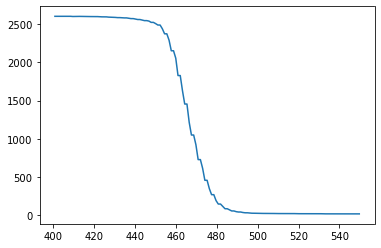

In [4]:
#print((pos > 100) & (pos < 2800))
iGood = np.where((pos > 400) & (pos < 550))
pos = pos[iGood]
I = I[iGood]
plt.plot(pos, I)

In [5]:
print(dataFile)
print(dataFile.find('/'))
figName = "Figures/" + dataFile[dataFile.find("/")+1:dataFile.rfind('.')] + r"_%.03d.png"
print(figName)
print(figName%12)

Data/2022-07-08-1331e.csv
4
Figures/2022-07-08-1331e_%.03d.png
Figures/2022-07-08-1331e_012.png


# Estimate Fit Parameters

In [6]:
IStart = np.median(I[:10])
IEnd = np.median(I[-10:])

def negErfc(x):
    return 2.0 - sp.special.erfc(x)

if IStart > IEnd:
    bErf = False
    fcn = sp.special.erfc
else:
    bErf = True
    fcn = negErfc
    
def beamProfile(pos, I0, pos0, width, IBack):
    return I0 * fcn((pos - pos0) / width) + IBack
    
I0Est = 0.5 * np.max([IStart, IEnd])
IBackEst = 0.5 * np.min([IStart, IEnd])
print(IStart, IEnd, I0Est)
halfIdx = (np.abs(I - I0Est)).argmin()
posEst = pos[halfIdx]
print(halfIdx, posEst)
eIdx = (np.abs(I - I0Est / np.sqrt(np.pi))).argmin()
widthEst = 2.0 * np.abs(pos[halfIdx] - pos[eIdx])
print(eIdx, pos[eIdx], I[eIdx], widthEst, IBackEst)

2602.14 19.3536 1301.07
60 466.625
64 470.996 729.446 8.741999999999962 9.6768


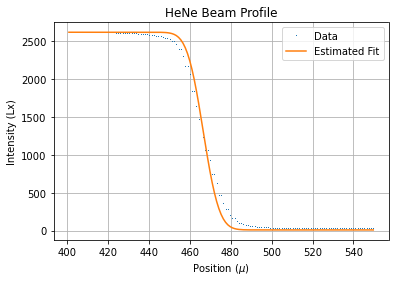

In [7]:
pos0 = posEst
width = widthEst
I0 = I0Est
IBack = IBackEst
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(pos, I, ',', label='Data')
#ax.set_xlim(-200,1200)
# ax.set_ylim(-200,16000)
ax.grid()
ax.plot(pos, beamProfile(pos, I0, pos0, width, IBack), label='Estimated Fit')
ax.legend()
ax.set_xlabel('Position ($\mu$)')
ax.set_ylabel('Intensity (Lx)')
ax.set_title('HeNe Beam Profile')
pass

# Do a Least-Squares Fit

In [8]:
initParams = np.array((I0Est, posEst, widthEst, IBackEst))
popt, pcov = curve_fit(beamProfile, pos, I, p0=initParams)
# print results
print("Initial Parameters = ", initParams)
print("Best Parameters = ", popt)
perr = np.sqrt(np.diag(pcov))
print("Uncertainty in parameters = ", perr)

(I0Fit, posFit, widthFit, IBackFit) = popt
(I0Unc, posUnc, widthUnc, IBackFitUnc) = perr
IFit = beamProfile(pos, I0Fit, posFit, widthFit, IBackFit)
print(eng_str(I0Fit, I0Unc, n=3))
print(eng_str(posFit, posUnc, n=1))
print(eng_str(widthFit, widthUnc, n=1))
print(eng_str(IBackFit, IBackFitUnc, n=1))


Initial Parameters =  [1301.07    466.625     8.742     9.6768]
Best Parameters =  [1282.49349222  466.376791     12.24022412   26.99975343]
Uncertainty in parameters =  [2.3308938  0.05879869 0.11365832 2.97354753]
1.282 ± 0.002e3
466.4 ± 0.1
12.2 ± 0.1
27.0 ± 3.0


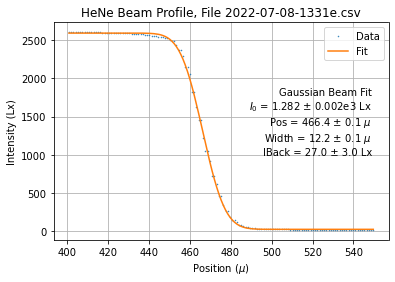

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(pos, I, '.', label='Data', ms=1)
#ax.set_xlim(-200,1200)
#ax.set_ylim(-200,16000)
ax.grid()
ax.plot(pos, IFit, label='Fit')
text = f"""Gaussian Beam Fit
$I_0$ = {eng_str(I0Fit, I0Unc, n=3)} Lx
Pos = {eng_str(posFit, posUnc, n=1)} $\mu$
Width = {eng_str(widthFit, widthUnc, n=1)} $\mu$
IBack = {eng_str(IBackFit, IBackFitUnc, n=1)} Lx"""
ax.legend()
ax.text(0.95, 0.7, text, horizontalalignment='right', verticalalignment='top', \
        transform=ax.transAxes)
ax.set_xlabel('Position ($\mu$)')
ax.set_ylabel('Intensity (Lx)')
ax.set_title(f'HeNe Beam Profile, File {dataFile[dataFile.find("20"):]}')
fig.savefig(figName%0, dpi=300)
pass

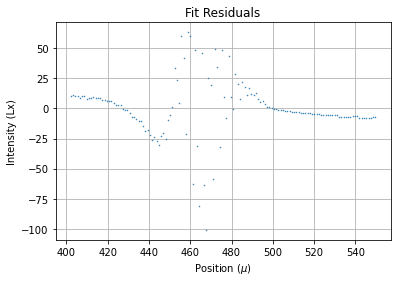

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(pos[1:], (I - IFit)[1:], '.', ms=1)
ax.grid()
ax.set_xlabel('Position ($\mu$)')
ax.set_ylabel('Intensity (Lx)')
ax.set_title('Fit Residuals')
fig.savefig(figName%1, dpi=300)
pass

# Beam Data

In [11]:
beamData = [
# D (mm), w(u), dw (u)
[58, 865.2, 2.5],
[58, 867.8, 2.4],
[58, 873.0, 2.5],
[58, 872.0, 2.2],
[58, 861.1, 2.2],
[87, 577.3, 2.8], 
[87, 572.7, 2.9], 
[87, 566.2, 2.6], 
[87, 574.6, 2.6], 
[87, 570.8, 3.2], 
[111, 347.3, 1.6], 
[111, 356.5, 1.8], 
[111, 350.4, 1/7], 
[111, 348.1, 1.7], 
[111, 357.1, 2.2], 
[138, 130.7, 0.6], 
[138, 131.9, 0.5], 
[138, 121.5, 0.7], 
[138, 121.0, 0.7], 
[138, 104.1, 0.4], 
[138, 112.4, 0.5], 
[138, 110.3, 0.5], 
[157, 59.0, 0.4], 
[157, 58.8, 0.4], 
[157, 61.6, 0.4], 
[157, 61.4, 0.3], 
[157, 60.7, 0.4], 
[184, 314.5, 3.0], 
[184, 324.9, 3.0], 
[184, 335.6, 3.4], 
[184, 307.8, 2.4], 
[184, 274.2, 1.3], 
[172, 233.6, 1.3], 
[172, 233.0, 1.4], 
[172, 231.1, 1.3], 
[172, 232.6, 1.4], 
[210, 553.5, 1.8], 
[210, 553.0, 1.8], 
[210, 553.3, 1.8], 
[210, 551.0, 1.8], 
[149.5, 12.3, 0.1], 
[149.5, 12.0, 0.1], 
[149.5, 11.3, 0.1], 
[149.5, 12.2, 0.1], 
]
beamData = np.array(beamData)
beamData = beamData[beamData[:, 0].argsort()]
D = beamData[:,0]
w = beamData[:,1]

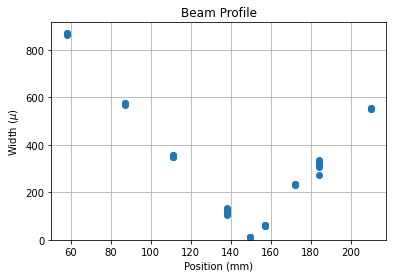

In [20]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(D, w, 'o')
ax.grid()
ax.set_xlabel('Position (mm)')
ax.set_ylabel('Width ($\mu$)')
ax.set_ylim(bottom=0)
ax.set_title('Beam Profile')
fig.savefig("Figures/Beam_Profile0-01.png", dpi=300)
pass

In [13]:
# Work in meters
lam = 532e-9
def GauBeam(z, w0, z0):
    global lam
    dz = z - z0
    return w0 * np.sqrt(1 + ((lam * dz) / (np.pi * w0**2))**2)

In [14]:
# Fit in meters
w0Est = 1e-6 * np.min(w)
z0Est = 1e-3 * D[np.where(1e-6 * w == w0Est)][0]
(w0Est, z0Est)

(1.13e-05, 0.1495)

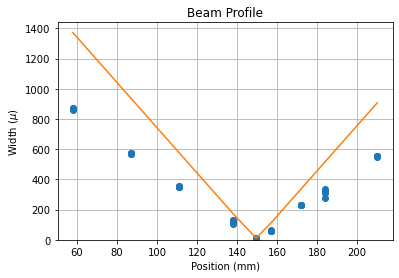

In [15]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(D, w, 'o')
ax.plot(D, 1e6 * GauBeam(1e-3 * D, w0Est, z0Est), '-')
ax.grid()
ax.set_xlabel('Position (mm)')
ax.set_ylabel('Width ($\mu$)')
ax.set_ylim(bottom=0)
ax.set_title('Beam Profile')
pass

In [16]:
initParams = np.array((w0Est, z0Est))
popt, pcov = curve_fit(GauBeam, 1e-3*D, 1e-6*w, p0=initParams)
# print results
print("Initial Parameters = ", initParams)
print("Best Parameters = ", popt)
perr = np.sqrt(np.diag(pcov))
print("Uncertainty in parameters = ", perr)

(w0Fit, z0Fit) = popt
(w0Unc, z0Unc) = perr
IFit = GauBeam(1e-3*D, w0Fit, z0Fit)
print(eng_str(w0Fit, w0Unc, n=2))
print(eng_str(z0Fit, z0Unc, n=5))


Initial Parameters =  [1.130e-05 1.495e-01]
Best Parameters =  [1.82063042e-05 1.49849929e-01]
Uncertainty in parameters =  [9.91193448e-08 2.63463471e-04]
18.21 ± 0.10e-6
0.14985 ± 0.00026


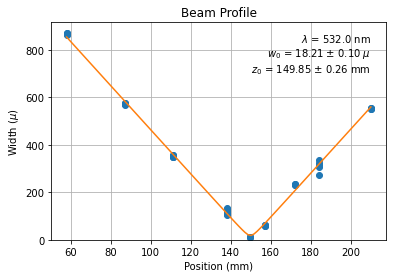

In [21]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(D, w, 'o')
DAxis = np.linspace(D[0], D[-1], 100)
ax.plot(DAxis, 1e6 * GauBeam(1e-3 * DAxis, w0Fit, z0Fit), '-')
ax.grid()
ax.set_xlabel('Position (mm)')
ax.set_ylabel('Width ($\mu$)')
ax.set_ylim(bottom=0)
ax.set_title('Beam Profile')
txt = f"""$\lambda$ = {1e9 * lam:.1f} nm
$w_0$ = {eng_str(1e6*w0Fit, 1e6*w0Unc, n=2)} $\mu$
$z_0$ = {eng_str(1e3*z0Fit, 1e3*z0Unc, n=2)} mm"""
ax.text(max(D), max(w), txt, ha='right', va='top')
fig.savefig("Figures/Beam_Profile0-02.png", dpi=300)
pass

In [18]:
pass